C:\Users\DELL\AppData\Local\Temp\ipykernel_87064\442079323.py:74: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(n_body_equations, y0, time, args=(masses,))


Stable intervals:
Mass: 0.0010, Offset: 0.10
Mass: 0.0010, Offset: 0.12
Mass: 0.0010, Offset: 0.14
Mass: 0.0010, Offset: 0.15
Mass: 0.0010, Offset: 0.16
Mass: 0.0010, Offset: 0.17
Mass: 0.0010, Offset: 0.18
Mass: 0.0010, Offset: 0.19
Mass: 0.0010, Offset: 0.21
Mass: 0.0010, Offset: 0.40
Mass: 0.0010, Offset: 0.64
Mass: 0.0010, Offset: 0.67
Mass: 0.0010, Offset: 0.68
Mass: 0.0010, Offset: 0.69
Mass: 0.0010, Offset: 0.94
Mass: 0.0011, Offset: 0.15
Mass: 0.0011, Offset: 0.17
Mass: 0.0011, Offset: 0.18
Mass: 0.0011, Offset: 0.19
Mass: 0.0011, Offset: 0.27
Mass: 0.0011, Offset: 0.28
Mass: 0.0011, Offset: 0.41
Mass: 0.0011, Offset: 0.55
Mass: 0.0011, Offset: 0.59
Mass: 0.0011, Offset: 0.68
Mass: 0.0011, Offset: 0.69
Mass: 0.0011, Offset: 0.70
Mass: 0.0011, Offset: 0.94
Mass: 0.0012, Offset: 0.15
Mass: 0.0012, Offset: 0.17
Mass: 0.0012, Offset: 0.18
Mass: 0.0012, Offset: 0.19
Mass: 0.0012, Offset: 0.21
Mass: 0.0012, Offset: 0.23
Mass: 0.0012, Offset: 0.26
Mass: 0.0012, Offset: 0.27
Mass: 0.00

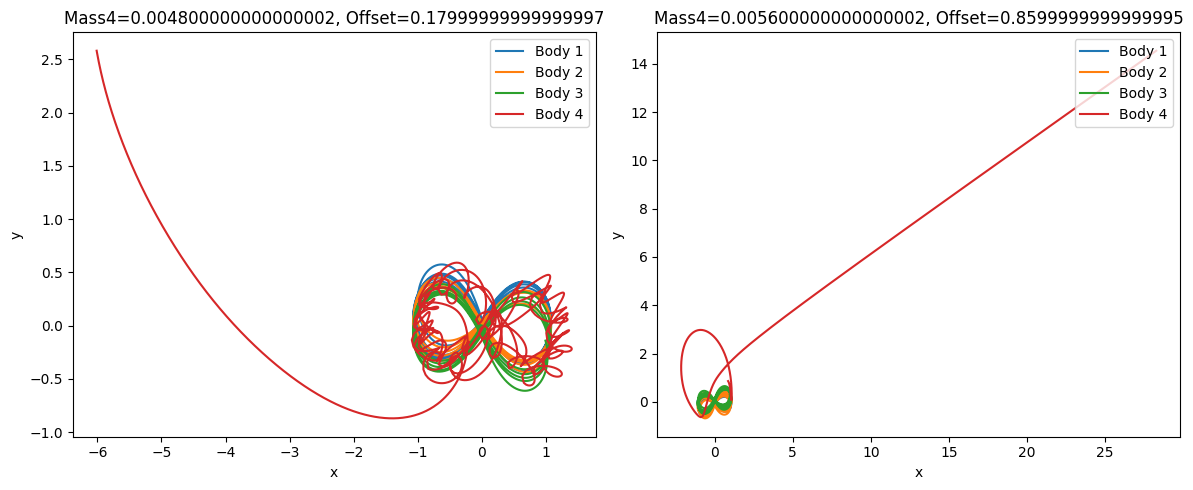

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Gravitational constant in chosen units
G = 1.0

# Original figure-8 initial conditions (three equal masses)
# The known solution often has:
# Masses = m1 = m2 = m3 = 1.0
# Initial positions and velocities (from a known set of initial conditions)
# For example (just a known figure-8 initial condition):
m1 = m2 = m3 = 1.0
m_default = 1.0  # mass for original three bodies
# A canonical figure-8 initial condition (one known set):
# Positions:
r1_init = np.array([0.97000436, -0.24308753])
r2_init = -r1_init
r3_init = np.array([0.0, 0.0])
# Velocities:
v1_init = np.array([0.466203685, 0.432365730])
v2_init = np.array([0.466203685, 0.432365730])
v3_init = - (v1_init + v2_init)

# Define a function to get the derivatives
def n_body_equations(y, t, masses):
    # y contains the positions and velocities of all bodies in the form:
    # y = [x1, y1, x2, y2, x3, y3, x4, y4, vx1, vy1, vx2, vy2, vx3, vy3, vx4, vy4]
    n_bodies = int(len(masses))
    positions = y[0:2*n_bodies].reshape(n_bodies, 2)
    velocities = y[2*n_bodies:4*n_bodies].reshape(n_bodies, 2)
    
    accelerations = np.zeros_like(positions)
    for i in range(n_bodies):
        for j in range(n_bodies):
            if i != j:
                diff = positions[j] - positions[i]
                dist = np.linalg.norm(diff)
                accelerations[i] += G * masses[j] * diff / dist**3
                
    dydt = np.concatenate([velocities.flatten(), accelerations.flatten()])
    return dydt

# Stability threshold (example):
distance_threshold = 10.0  # You can choose a suitable threshold based on tests

# Parameter ranges
vel_positions = np.arange(0.1, 1.01, 0.01)  # For position and velocity variations
mass_values = np.arange(0.001, 0.0101, 0.0001)

# Time parameters
t_max = 30.0  # total integration time (should cover multiple periods)
time = np.linspace(0, t_max, 3000)  # for higher resolution

stable_intervals = []
unstable_intervals = []

for mass_4 in mass_values:
    for init_offset in vel_positions:
        # Here, let's define the 4th body's initial conditions
        # For simplicity, assume we place the asteroid near the origin but offset by init_offset
        # and give it a small initial velocity also scaled by init_offset.
        # Adjust according to your preference:
        r4_init = np.array([init_offset, init_offset])
        v4_init = np.array([init_offset * 0.5, -init_offset * 0.5])
        
        masses = np.array([m1, m2, m3, mass_4])
        
        # Initial conditions vector
        y0 = np.concatenate([r1_init, r2_init, r3_init, r4_init, 
                             v1_init, v2_init, v3_init, v4_init])

        # Integrate the system
        sol = odeint(n_body_equations, y0, time, args=(masses,))
        
        # Extract positions
        pos = sol[:, 0:8].reshape(len(time), 4, 2)  # 4 bodies, 2D positions

        # Check pairwise distances over time
        # We want max distance between any two bodies
        max_dist = 0.0
        for snapshot in pos:
            for i in range(4):
                for j in range(i+1, 4):
                    dist = np.linalg.norm(snapshot[j] - snapshot[i])
                    if dist > max_dist:
                        max_dist = dist
                        # If max_dist already exceeds threshold, we can break early
                        if max_dist > distance_threshold:
                            break

        if max_dist > distance_threshold:
            unstable_intervals.append((mass_4, init_offset))
        else:
            stable_intervals.append((mass_4, init_offset))

# Print results
print("Stable intervals:")
for interval in stable_intervals:
    print("Mass: {:.4f}, Offset: {:.2f}".format(interval[0], interval[1]))
    
print("Unstable intervals:")
for interval in unstable_intervals:
    print("Mass: {:.4f}, Offset: {:.2f}".format(interval[0], interval[1]))


# Plotting a few snapshots
# Let's pick one stable and one unstable scenario and plot their trajectories
def plot_trajectory(mass_4, init_offset, ax):
    # Repeat the simulation for plotting
    r4_init = np.array([init_offset, init_offset])
    v4_init = np.array([init_offset * 0.5, -init_offset * 0.5])
    masses = np.array([m1, m2, m3, mass_4])
    y0 = np.concatenate([r1_init, r2_init, r3_init, r4_init, v1_init, v2_init, v3_init, v4_init])
    sol = odeint(n_body_equations, y0, time, args=(masses,))
    pos = sol[:, 0:8].reshape(len(time), 4, 2)
    for i in range(4):
        ax.plot(pos[:, i, 0], pos[:, i, 1], label=f'Body {i+1}')
    ax.set_title(f'Mass4={mass_4}, Offset={init_offset}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper right')

# Pick a stable example (if available)
if stable_intervals:
    stable_example = stable_intervals[len(stable_intervals)//2]
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    plot_trajectory(stable_example[0], stable_example[1], axes[0])

# Pick an unstable example (if available)
if unstable_intervals:
    unstable_example = unstable_intervals[len(unstable_intervals)//2]
    plot_trajectory(unstable_example[0], unstable_example[1], axes[1])

plt.tight_layout()
plt.show()